# Introducción al Análisis de Supervivencia con sckit-survival

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")  # displays text representation of estimators

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


## Datos

El Ensayo de Cáncer de Pulmón de la Administración de Veteranos es un ensayo aleatorizado de dos regímenes de tratamiento para el cáncer de pulmón. El conjunto de datos (Kalbfleisch J. y Prentice R, (1980) The Statistical Analysis of Failure Time Data. Nueva York: Wiley) consta de 137 pacientes y 8 variables, que se describen a continuación:    

- Treatment: denota el tipo de tratamiento del cáncer de pulmón; standard y test.
- Celltype: denota el tipo de célula involucrada; squamous, small cell, adeno, large.
- Karnofsky_score: es la partitura de Karnofsky.
- Diag: es el tiempo transcurrido desde el diagnóstico en meses.
- Age: es la edad en años.
- Prior_Therapy: denota cualquier terapia previa; none o yes.
- Status: denota el estado del paciente como vivo o muerto; alive o dead.
- Survival_in_days: es el tiempo de supervivencia en días transcurridos desde el tratamiento.

In [2]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

## Modelos de Supervivencia Univariado : Kaplan-Meier

Una cantidad clave en el análisis de supervivencia es la llamada función de supervivencia, que relaciona el tiempo con la probabilidad de sobrevivir más allá de un punto de tiempo dado.

Dejar $T$ denotan una variable aleatoria continua no negativa correspondiente al tiempo de supervivencia de un paciente. La función de supervivencia $S(t)$ devuelve la probabilidad de supervivencia más allá del tiempo y se define como

$ S(t) = P( T > t ) $

In [3]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


Text(0.5, 0, 'time $t$')

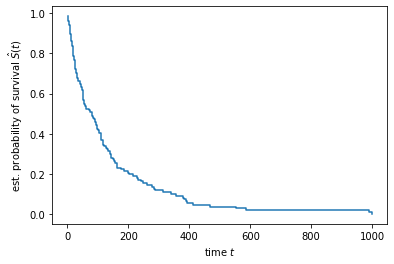

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

### Función Kaplan-Meier por grupo

Los pacientes inscritos en el Ensayo de Cáncer de Pulmón de la Administración de Veteranos fueron asignados al azar a uno de dos tratamientos: standard y un nuevo medicamento test. 

In [5]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

#### Por tipo de Tratamiento

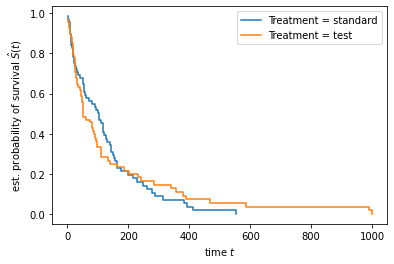

In [6]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

#### Por tipo de Celula

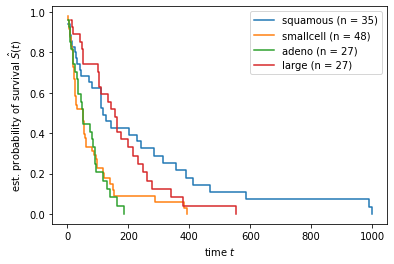

In [7]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Modelos de Supervivenia Multivariado

### Modelo de Riesgo Proporcional de Cox

In [ ]:
# Primero, sin embargo, necesitamos convertir las variables categóricas en el conjunto de datos en valores numéricos.

from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [9]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

El resultado es un vector de coeficientes, uno para cada variable, donde cada valor corresponde a la razón de riesgo logarítmica.

In [11]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

### Nuevas predicciones

In [13]:
# Datos de pacientes sinteticos

x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


Similar a kaplan_meier_estimator, el método predict_survival_function devuelve la función de supervivencia, que podemos graficar.

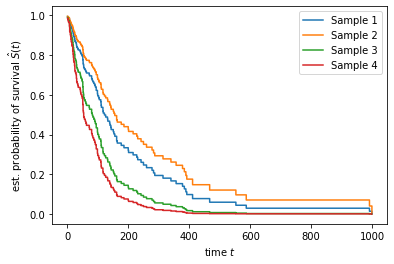

In [14]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)

time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Metricas de Rendimiento

Se utiliza la generalización del área bajo la curva de características operativas del receptor (ROC) llamada índice de concordancia de Harrell o índice c.

### Indice C

$\sum_{j=1}^{n(h)} \hat{H}_h(T_{j} \mid x)$

In [60]:
estimator.predict?

Signature: estimator.predict(X, check_input=True)
Docstring:
Predict risk score.

The risk score is the total number of events, which can
be estimated by the sum of the estimated cumulative
hazard function :math:`\hat{H}_h` in terminal node :math:`h`.

.. math::

    \sum_{j=1}^{n(h)} \hat{H}_h(T_{j} \mid x) ,

where :math:`n(h)` denotes the number of distinct event times
of samples belonging to the same terminal node as :math:`x`.

Parameters
----------
X : array-like, shape = (n_samples, n_features)
    Data matrix.

check_input : boolean, default: True
    Allow to bypass several input checking.
    Don't use this parameter unless you know what you do.

Returns
-------
risk_scores : ndarray, shape = (n_samples,)
    Predicted risk scores.
File:      ~/.local/lib/python3.10/site-packages/sksurv/tree/tree.py
Type:      method


In [15]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.7362562471603816

In [59]:
np.exp(prediction)

array([0.02384557, 0.01931031, 0.0310935 , 0.02697843, 0.01913535,
       0.10433844, 0.04920934, 0.01249951, 0.04122681, 0.0170632 ,
       0.02152643, 0.05157123, 0.06680799, 0.01543514, 0.02212875,
       0.06015043, 0.07072052, 0.14426618, 0.03310055, 0.06277167,
       0.12158086, 0.05713221, 0.06350155, 0.15468558, 0.03561104,
       0.1842199 , 0.07777674, 0.05665106, 0.03924415, 0.13071222,
       0.26061714, 0.03053453, 0.15464289, 0.03563489, 0.04569642,
       0.06183095, 0.1614116 , 0.05715324, 0.03346532, 0.05961095,
       0.04124455, 0.07584215, 0.09308121, 0.10878191, 0.11773932,
       0.33175096, 0.06096803, 0.15953611, 0.05314137, 0.04794654,
       0.12273336, 0.04253787, 0.26013546, 0.05497999, 0.05430359,
       0.01966464, 0.05694283, 0.03098665, 0.03741467, 0.07400086,
       0.02274083, 0.02528073, 0.02634076, 0.01419487, 0.01443171,
       0.01899303, 0.02414333, 0.03162774, 0.05022849, 0.01462878,
       0.01792393, 0.01986593, 0.05488974, 0.04380528, 0.02908

# Modelos Cox Penalizados

# Survival Tree

In [24]:
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.tree import SurvivalTree

In [69]:
X, y = load_whas500()
X = X.astype(float)

In [72]:
estimator = SurvivalTree().fit(X, y)

In [73]:
X.iloc[:5]

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1.0,83.0,0.0,25.54051,0.0,1.0,78.0,0.0,89.0,5.0,1.0,0.0,0.0,152.0
1,0.0,49.0,0.0,24.02398,0.0,1.0,60.0,0.0,84.0,5.0,0.0,1.0,0.0,120.0
2,0.0,70.0,0.0,22.14290,0.0,0.0,88.0,1.0,83.0,5.0,0.0,1.0,0.0,147.0
3,0.0,70.0,0.0,26.63187,1.0,1.0,76.0,0.0,65.0,10.0,0.0,1.0,0.0,123.0
4,0.0,70.0,0.0,24.41255,0.0,1.0,85.0,0.0,63.0,6.0,0.0,1.0,0.0,135.0


In [74]:
pd.DataFrame.from_dict(y).head()

,fstat,lenfol
0,False,2178.0
1,False,2172.0
2,False,2190.0
3,True,297.0
4,False,2131.0


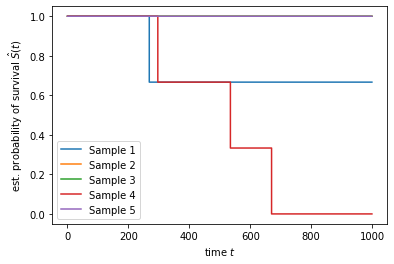

In [75]:
pred_surv = estimator.predict_survival_function(X.iloc[:5])

time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Random Survival Forests

Los arboles de supervivencia son arboles de clasificación y regresión capaces de trabajar con datos censurados. El enfoque particular se basa en como dividir los nodos de decisión, siendo la principal diferencia entre un árbol de clasificación, en la elección del criterio de división del nodo. El criterio de división se agrupa en dos categorías: (1) minimizar la homogeneidad dentro de los nodos, o (2) maximizar la heterogeneidad entre nodos. El primer enfoque minimiza la función de pérdida utilizando el criterio de homogeneidad dentro del nodo. El segundo enfoque utiliza la prueba estadística log-rank para medidas de heterogeneidad entre nodos [[fuente](https://doi.org/10.48550/arXiv.1708.04649)].

Un bosque de supervivencia aleatorio garantiza que los árboles individuales se descorrelacionen 1) construyendo cada árbol en una muestra de arranque diferente de los datos de entrenamiento originales, y 2) en cada nodo, solo evalúe el criterio de división para un subconjunto de características y umbrales seleccionados al azar. Las predicciones se forman agregando predicciones de árboles individuales en el conjunto. 

El objetivo es predecir el tiempo de supervivencia libre de recurrencia.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [77]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

In [78]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [79]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

Podemos comprobar qué tan bien funciona el modelo evaluándolo en los datos de prueba.

In [80]:
rsf.score(X_test, y_test)

0.6759696016771488

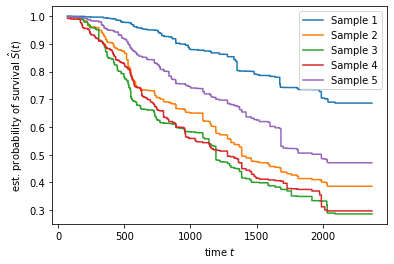

In [83]:
pred_surv = rsf.predict_survival_function(X_train.iloc[:5])

time_points = np.arange(72, 2372)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")